In [87]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

In [88]:
using Plots
gr()  

Plots.GRBackend()

## imagine a liquid slug get accelerated in an infinitely long tube by a constant pressure difference

To get analytical solution, we need

$\begin{equation}
    A_{\mathrm{c}} L_{\mathrm{l},i} \rho_{\mathrm{l}} \frac{\mathrm{d}^{2} \xi_{\mathrm{l},2i-1} }{\mathrm{~d} t^{2}}=\left(p_{\mathrm{v},i}-p_{\mathrm{v},i+1}\right) A_{\mathrm{c}}- \rho_{\mathrm{l}} g \Delta H_{\mathrm{l},i} A_{\mathrm{c}} -P L_{\mathrm{l},i} \tau_{\mathrm{l},i}.
    \label{eq:momentum}
\end{equation}$




$\begin{equation}
   A \frac{\mathrm{d}^{2} \xi }{\mathrm{~d} t^{2}}=C + 0 -B \frac{\mathrm{d} \xi}{\mathrm{d} t}.
    \label{eq:momentum}
\end{equation}$

$\xi(0) = 0$

$\xi'(0) = 0$

solution:

$\xi = c_1 + c_2 e^{-\frac{B}{A}\xi} + \frac{C}{B} \xi$

plugging in I.C.

$\xi = \frac{AC}{B^2} e^{-\frac{B}{A}\xi} + \frac{C}{B} \xi$

$\frac{\mathrm{d} \xi}{\mathrm{d} t} = -\frac{C}{B} e^{-\frac{B}{A}\xi} + \frac{C}{B}$

### conduction only

# Properies

### Earth property

In [89]:
g = 9.8

9.8

### Solid Physical parameters

In [90]:
ρₛ = 2700; # density
cₛ  = 8.97e02; # specific heat
kₛ  = 1.67e02; # heat conductivity
# d = 2e-3;
plate_d = 2e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Fluid Physical parameters

In [91]:
fluid_type = "butane"
Tᵥ = 295.0

295.0

In [92]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [93]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [94]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [95]:
inch = 2.54e-2;

In [96]:
power = 40 *0 #watts
total_heater_area = 2.0inch*2.0inch;

In [97]:
qe = power/total_heater_area
hc = 1500.0 * 0
Tc = Tᵥ

295.0

In [98]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [99]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = plate_d
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
one_loop_gap = 1e-2
x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


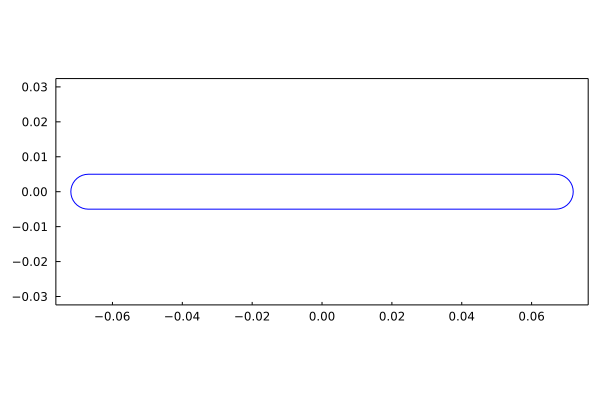

In [100]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [101]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{362,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [102]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


# OHP inner part

### Tube geometries

In [103]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [104]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [105]:
Nu = 4.36
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

462.26761711088227

In [106]:
# X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)
X0 = [(L/2,L/2+0.5L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0)) 
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)

# dXdt0[2] = (1.0,1.0)

1-element Array{Tuple{Float64,Float64},1}:
 (0.0, 0.0)

In [107]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [108]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [109]:
P = 0*zeros(length(X0)) .+ TtoP.([Tᵥ]);
δ = 0*zeros(length(X0)) .+ 0.1*tube_d;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(kₗ,P,δ);

In [110]:
P

1-element Array{Float64,1}:
 220337.82769062277

### Wall

nucleate boiling sites

In [111]:
ΔTthres = 100.0; # superheat threshold

    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [112]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [113]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [114]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [115]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [116]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# Prescribed pressure difference of liquid i

We introduce a prescribed pressure difference for liquid i

In [117]:
L2D

0.13383

In [118]:
Amp = L2D * 1e-4
frequency = 10.0

Pres_X(Xinit::Float64,t::Float64) = Xinit + Amp*sin(2*pi*frequency*t)

Pres_X (generic function with 1 method)

# combine inner tube and plate together

In [119]:
tspan = (0.0, 0.5);
dt_record = tspan[2] /200;

tstep=1e-3

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [120]:
ΔT = 0.0 #[K]

0.0

In [121]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ + ΔT;

In [122]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

In [123]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [124]:
push!(plate_hist,deepcopy(integrator_plate)); 
push!(tube_hist,deepcopy(integrator_tube));

In [125]:
currentsys.liquid.Xp[1][1]

0.14966946308817156

In [126]:
integrator_tube.u

87-element Array{Float64,1}:
   0.14966946308817156
   0.21658446308817156
   0.0
   0.0
   1.3059965648833786e-6
   0.0001
  -1.0e10
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
   ⋮
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0

In [127]:

@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        
        
#         mindex = Int64(1)
#         integrator_tube.u[2*mindex-1:2*mindex] = [Pres_X(X0[mindex][1],t),Pres_X(X0[mindex][2],t)]
#         println(integrator_tube.u[2*mindex-1:2*mindex])
#         currentsys.liquid.Xp[mindex][2] = Pres_X(X0[mindex][2],t)
        
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

#         qtmp = sys_to_heatflux(currentsys)
#         set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.005
0.010000000000000002
0.015000000000000006
0.02000000000000001
0.025000000000000015
0.03000000000000002
0.035000000000000024
0.04000000000000003
0.04500000000000003
0.05000000000000004
0.05500000000000004
0.060000000000000046
0.06500000000000004
0.07000000000000005
0.07500000000000005
0.08000000000000006
0.08500000000000006
0.09000000000000007
0.09500000000000007
0.10000000000000007
0.10500000000000008
0.11000000000000008
0.11500000000000009
0.12000000000000009
0.12500000000000008
0.1300000000000001
0.1350000000000001
0.1400000000000001
0.1450000000000001
0.1500000000000001
0.1550000000000001
0.16000000000000011
0.16500000000000012
0.17000000000000012
0.17500000000000013
0.18000000000000013
0.18500000000000014
0.19000000000000014
0.19500000000000015
0.20000000000000015
0.20500000000000015
0.21000000000000016
0.21500000000000016
0.22000000000000017
0.22500000000000017
0.23000000000000018
0.23500000000000018
0.24000000000000019
0.2450000000000002
0.25000000000000017
0.25500000000000

In [128]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

# plot the OHP

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
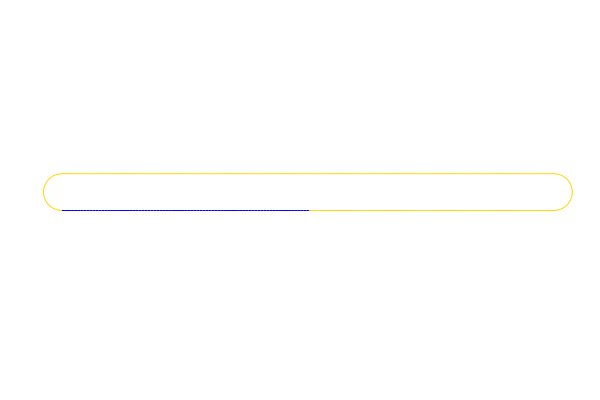

In [129]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
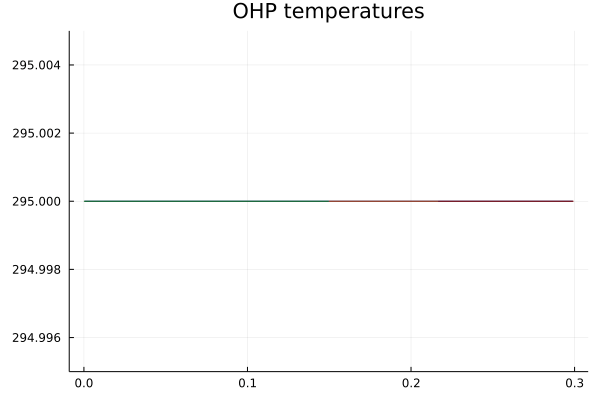

In [130]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T",ylim=(295.0-0.005,295.0+0.005))
end

In [131]:
Xp_hist1 = []
for ii = 1:length(sysfinal)
    push!(Xp_hist1,sysfinal[ii].liquid.Xp[1][2])
end
Xp_hist1

101-element Array{Any,1}:
 0.21658446308817156
 0.2169036712936324
 0.21784237309703278
 0.2193731293393166
 0.22146971622096046
 0.2241070714701928
 0.2272612428955784
 0.23090933921735673
 0.23502948307660274
 0.23960076612574716
 0.2446032061082675
 0.25001770583944316
 0.2558260140039715
 ⋮
 0.2815905462093959
 0.29564796327616977
 0.0103774428512593
 0.0244563505667984
 0.03854529508414939
 0.05264383184439786
 0.06675153597942668
 0.08086800143975353
 0.09499284016099946
 0.10912568126727656
 0.12326617030986009
 0.13741396853958232

In [132]:
dXdt_hist1 = []
for ii = 1:length(sysfinal)
    push!(dXdt_hist1,sysfinal[ii].liquid.dXdt[1][2])
end
dXdt_hist1

101-element Array{Any,1}:
 0.0
 0.12672645009257574
 0.24783982003020394
 0.36358872932998504
 0.4742107854331935
 0.5799330714618927
 0.6809726123714009
 0.7775368204555215
 0.8698239211190583
 0.9580233597916394
 1.0423161908181537
 1.1228754491241062
 1.1998665054188442
 ⋮
 2.8103509792757024
 2.8125988749805693
 2.8147472048981665
 2.816800379084517
 2.818762612261539
 2.8206379324689546
 2.8224301893329815
 2.8241430619687855
 2.8257800665329045
 2.827344563441158
 2.828839764266851
 2.8302687383334404

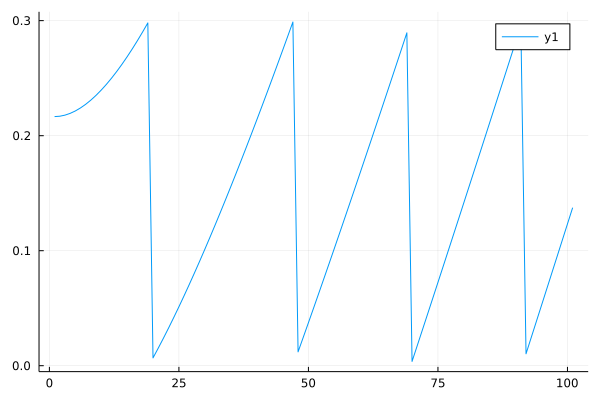

In [133]:
plot(Xp_hist1)
# plot!(Xp_hist2 .- Xp_hist2[1])

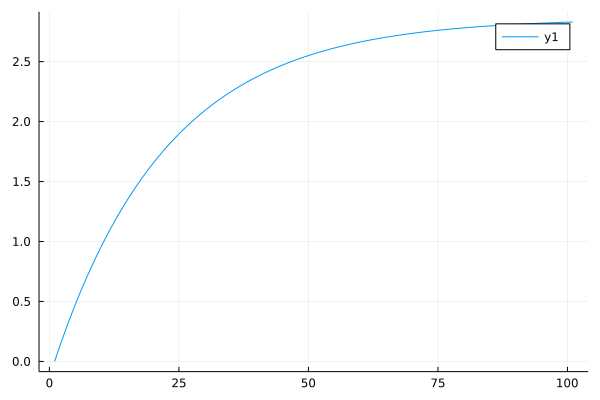

In [134]:
plot(dXdt_hist1)

In [135]:
Ls = X0[1][2]-X0[1][1]

0.066915

In [136]:
ρₗ

576.4727745885054

In [137]:
A = Ac*Ls*ρₗ

3.8574675711589845e-5

In [138]:
B = 8*μₗ/tube_d * peri * Ls

0.00034951571322190515

In [139]:
ΔP = 1e3
C = ΔP*Ac

0.001

In [140]:
ts=tspan[1]:tstep:tspan[2]

0.0:0.001:0.5

In [141]:
yy = A*C/B/B*exp.(-B/A .* ts) + C/B .* ts

501-element Array{Float64,1}:
 0.3157685504242011
 0.31578147323636696
 0.3158200861400426
 0.31588415741495035
 0.3159734574308904
 0.3160877586288882
 0.31622683550251285
 0.3163904645793632
 0.3165784244027215
 0.3167904955133718
 0.3170264604315834
 0.3172861036392559
 0.3175692115622256
 ⋮
 1.4028382821398082
 1.4056654733077474
 1.408492970342914
 1.411320770486437
 1.4141488710043308
 1.416977269187269
 1.4198059623503636
 1.422634947832943
 1.4254642229983356
 1.428293785233651
 1.4311236319495673
 1.4339537605801171

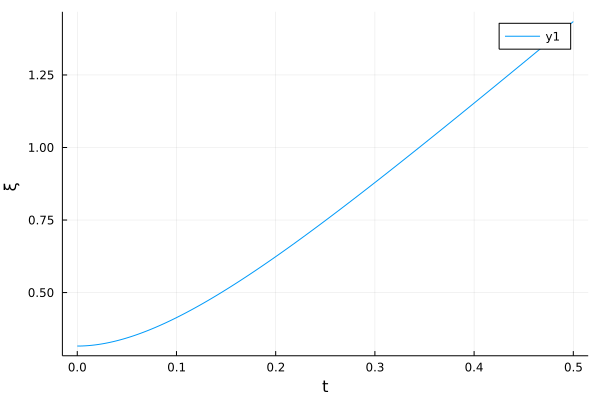

In [142]:
plot(ts,yy,ylabel="ξ ",xlabel="t")

In [143]:
yydξ = -C/B .* exp.(-B/A .* ts) .+ C/B

501-element Array{Float64,1}:
 0.0
 0.025806653088464415
 0.05138053453358715
 0.07672374389619607
 0.10183836179943695
 0.12672645009958616
 0.15139005205532596
 0.17583119249549117
 0.20005187798530244
 0.2240540969911029
 0.24783982004360405
 0.2714109998996652
 0.2947695717026093
 ⋮
 2.8270373084357416
 2.8273445634496697
 2.8276490470753717
 2.827950784310301
 2.828249799926437
 2.828546118472321
 2.82883976427507
 2.8291307614423746
 2.8294191338644787
 2.8297049052161394
 2.829988098958572
 2.830268738341376

In [144]:
q_plate = []
t_hist = []
for i=1:length(plate_hist)
    dT=deepcopy(plate_hist[i].p.qline[1].cache1);
    heatconduction_rhs!(dT,temperature(plate_hist[1]),plate_hist[i].p,0.0);
    push!(q_plate, dT ./ fact)
    push!(t_hist, plate_hist[i].t)
end

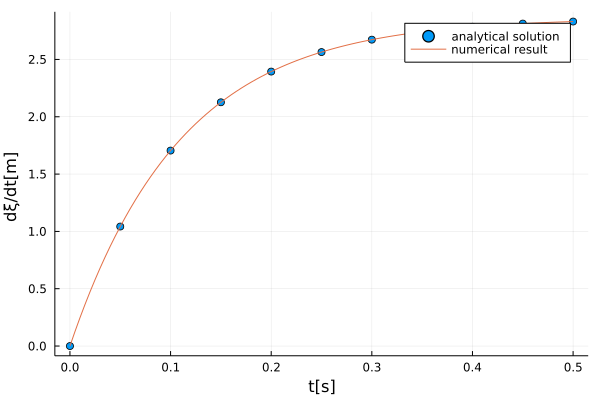

In [173]:
scatter(ts[1:50:end],yydξ[1:50:end],marker=:auto,label="analytical solution")
plot!(t_hist,dXdt_hist1,label="numerical result",ylabel="dξ/dt[m] ",xlabel="t[s]")

In [146]:
q_tube_lines = sys_to_heatflux.(sysfinal);

In [147]:
function add_qline(q_tube_lines)
    q_temp = zeros(length(q_tube_lines))
    for i = 1:length(q_tube_lines)
        q_temp[i] = sum(q_tube_lines[i] .* areas(sys.qline[1].body))
    end
    
    q_temp
end

add_qline (generic function with 1 method)

In [148]:
q_tube_hist = add_qline(q_tube_lines);

In [149]:
fact = 1.0/(ρₛ*cₛ*plate_d)

0.00020644948181180065

In [150]:
q_plate = []
t_hist = []
for i=1:length(plate_hist)
    dT=deepcopy(plate_hist[i].p.qline[1].cache1);
    heatconduction_rhs!(dT,temperature(plate_hist[1]),plate_hist[i].p,0.0);
    push!(q_plate, dT ./ fact)
    push!(t_hist, plate_hist[i].t)
end

In [151]:
q_plate_hist = cellsize(sys)^2 * sum.(q_plate);

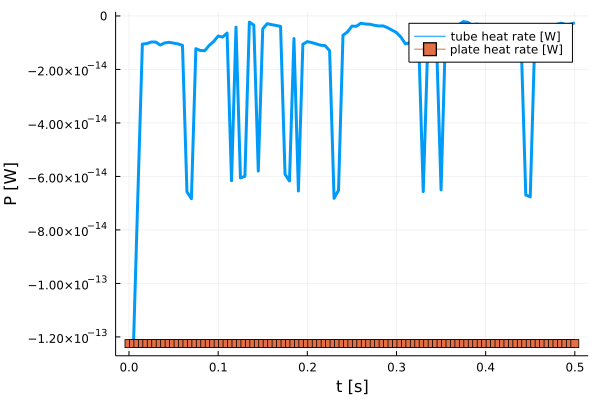

In [152]:
plot(t_hist,q_tube_hist,linewidth=3.0,label="tube heat rate [W]")
plot!(t_hist,-q_plate_hist,ylabel="P [W]",xlabel="t [s]",markershape=:auto,label="plate heat rate [W]",legend=:topright)
# savefig("validation.pdf")

In [153]:
norm((q_tube_hist+q_plate_hist) ./ q_tube_hist,Inf)

57.46716112110144

### Compare with analytical result at the beginning

In [154]:
Lliquidslug = XptoLliquidslug(sys0.liquid.Xp,sys0.tube.L)

1-element Array{Float64,1}:
 0.066915

In [155]:
Lvaporslug = XptoLvaporplug(sys0.liquid.Xp,sys0.tube.L,closedornot)

1-element Array{Float64,1}:
 0.2324239261763431

In [156]:
Hᵥ=kₗ/δ[1]

1060.2468282359685

In [157]:
ΔT * (Hᵥ * peri * Lvaporslug[1] + Hₗ * peri * Lliquidslug[1])

0.0

In [158]:
dPdT = CoolProp.PropsSI("d(P)/d(T)|sigma","T",Tᵥ,"Q",1.0,fluid_type)

7014.223504211973

In [159]:
dρdT = CoolProp.PropsSI("d(D)/d(T)|sigma","T",Tᵥ,"Q",1.0,fluid_type)

0.16927005777799287

In [160]:
dPdρ = dPdT/dρdT

41438.06409879956

In [161]:
M[1]

1.3059965648833786e-6

In [162]:
Ac

1.0e-6

In [163]:
ρᵥ

5.619013384142316

In [164]:
k = Ac^2/M[1] * dPdρ * (-ρᵥ^2)

-1.0017919933688895

$\xi'_{3} = \xi'_{4} = A_{\mathrm{m}} \sin(2 \pi f t)$


$F_{1} = F_{0} -k(\xi'_{1} - \xi'_{4})$

$F_{2} = F_{0} -k(\xi'_{3} - \xi'_{2})$


$\begin{equation}
   A \frac{\mathrm{d}^{2} \xi'_{1} }{\mathrm{~d} t^{2}} + B \frac{\mathrm{d} \xi'_{1}}{\mathrm{d} t} = 2k (\xi'_{3} - \xi'_{1})
\end{equation}$

In [165]:
(B*ω)^2

0.00048227322025863546

In [166]:
(2k-A*ω^2)^2

4.647778485497971

In [167]:
ω = 2π*frequency
D = Amp*sqrt((2k-A*ω^2)^2 + (B*ω)^2 )
κ = asin(Amp*(B*ω) /D)

0.01018612126554822

In [168]:
D

2.8853514475382936e-5

In [169]:
frequency

10.0

In [170]:
Amp= 1e-4

0.0001

In [171]:
D

2.8853514475382936e-5

In [172]:
Dₗ = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)

5.619013384142316